In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import tqdm as tqdm

In [3]:
import sys
import os

# # Add the poligrain and mergeplg src directories to Python's path
sys.path.insert(0, os.path.abspath("./mergeplg/src"))
sys.path.insert(0, os.path.abspath("./poligrain/src"))
sys.path.insert(0, os.path.abspath("./pycomlink"))

# Import submodules
import pycomlink as pycml
import poligrain as plg
from mergeplg import interpolate, merge

/home/erlend/Documents/GitHub/OpenMRG2/pycomlink/pycomlink/io/examples.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [4]:
# OpenMRG
ds_gauges = xr.open_dataset("data/andersson_2022_OpenMRG/gauges/openmrg_gauges.nc")
ds_rad = xr.open_dataset("data/andersson_2022_OpenMRG/radar/openmrg_rad.nc")
ds_cmls = xr.open_dataset("data/processed_cml_OpenMRG.nc") 

In [5]:
# Focus on small time window
start = "2015-07-25T12:30"
end = "2015-07-25T15:00"

ds_gauges = ds_gauges.sel(time = slice(start, end))
ds_rad = ds_rad.sel(time = slice(start, end)) 
ds_cmls = ds_cmls.sel(time = slice(start, end)) 

# Rename for naming conventions
ds_gauges = ds_gauges.rename({"longitude": "lon", "latitude": "lat"})

In [6]:
# Threshold lower values
radar_zero = 0.01  # here in sum mm over 15 minutes
ds_rad["rainfall_amount"] = xr.where(
    ds_rad.rainfall_amount > radar_zero, ds_rad.rainfall_amount, 0
)

# Project data

In [7]:
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

In [8]:
# Project OpenMRG data
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, ref_str
)

# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

# Projected radar coords
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = plg.spatial.project_point_coordinates( 
    ds_rad.lon, ds_rad.lat, ref_str
)


# Closest municipal rain gauges to SMHI rain gauge

In [9]:
n_closest = 3
id_smhi = 'SMHI'
id_municip = ['Jarn', 'Torp', 'Bergsj', 'Torsl', 'Chalm', 'Tole', 'Barl', 'Drakeg', 'Lbom', 'Askim']
# Get the n closest netatmo to SMHI
closest = plg.spatial.get_closest_points_to_point(
    ds_gauges.sel(id = id_smhi),
    ds_gauges.sel(id = id_municip),
    max_distance=10000,
    n_closest = n_closest
).isel(id = 0).neighbor_id.data

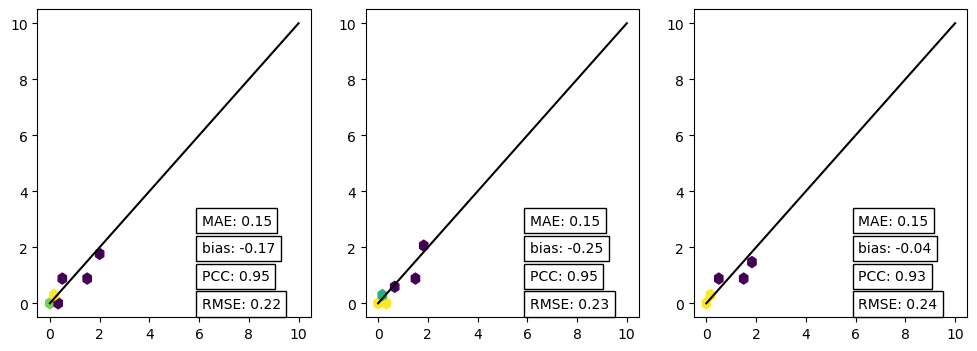

In [10]:
fig, ax = plt.subplots(1, n_closest, figsize=(n_closest*4,4))
for i, id in enumerate(closest):
    ground = ds_gauges.sel(id = id_smhi).R.data
    tar = ds_gauges.R.sel(id = id).data
    keep = np.ones(tar.size).astype(bool)
    ax[i].hexbin(
        ground,
        tar,
        gridsize=30,
        extent=[0, 10, 0, 10],
        mincnt=1,
        bins = 'log'
    )
    ax[i].plot([0, 10], [0, 10], 'k')

    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )


# Closest CMLs to SMHI

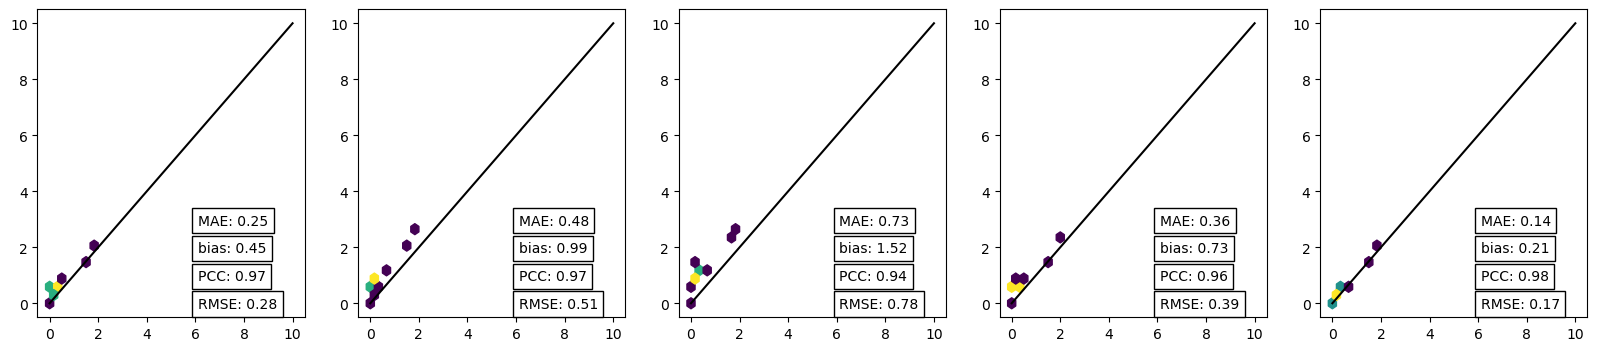

In [11]:
n_closest = 5
cml_rain = ds_cmls.R.sel(time=ds_gauges.time)

# Get the n closest netatmo to SMHI
closest = plg.spatial.get_closest_points_to_point(
    ds_gauges.sel(id = id_smhi),
    ds_cmls.rename({'cml_id':'id'}),
    max_distance=10000,
    n_closest = n_closest
).isel(id = 0).neighbor_id.data

fig, ax = plt.subplots(1, n_closest, figsize=(n_closest*4,4))
for i, id in enumerate(closest):
    ground = ds_gauges.sel(id = id_smhi).R.data
    tar = cml_rain.sel(cml_id = id).data
    keep = np.ones(tar.size).astype(bool)
    ax[i].hexbin(
        ground,
        tar,
        gridsize=30,
        extent=[0, 10, 0, 10],
        mincnt=1,
        bins = 'log'
    )
    ax[i].plot([0, 10], [0, 10], 'k')

    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )


# Estimate rainfall fields

In [12]:
# Define variogram parameters used by kriging
variogram_parameters = {"sill": 0.9, "range": 10000, "nugget": 0.4}
variogram_model = "exponential"

# Number of neighbours to use for interpolation
nnear = 12

## Interpolate ground observations

### IDW Interpolation

In [13]:
interpolator = interpolate.InterpolateIDW(
    ds_grid=ds_rad.rainfall_amount,
    ds_cmls=ds_cmls,
    nnear=nnear,
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        interpolator(
            da_cmls=ds_cmls.R.sel(time=time),
        )
    )
ds_rad["rainfall_interpolateIDW"] = xr.concat(rainfall, dim="time")



### Block kriging interpolation

In [14]:
interpolator = interpolate.InterpolateOrdinaryKriging(
    ds_grid=ds_rad.rainfall_amount,
    ds_cmls=ds_cmls,
    full_line=True,
    variogram_parameters=variogram_parameters,
    nnear=nnear,
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        interpolator(
            da_cmls=ds_cmls.R.sel(time=time),
            # da_cmls_sigma=ds_cmls.sigma_R.sel(time = time),
        )
    )
ds_rad["rainfall_interpolateBKline"] = xr.concat(rainfall, dim="time")

## Adjust radar

### IDW additive adjust

In [15]:
merger = merge.MergeDifferenceIDW(
    ds_rad=ds_rad.rainfall_amount,
    ds_cmls=ds_cmls,
    method="additive",
    nnear=nnear,
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            da_rad=ds_rad.sel(time=time).rainfall_amount,
            da_cmls=ds_cmls.R.sel(time=time),
        )
    )
ds_rad["rainfall_additiveIDW"] = xr.concat(rainfall, dim="time")

### Block kriging additive adjust

In [16]:
merger = merge.MergeDifferenceOrdinaryKriging(
    ds_rad=ds_rad.rainfall_amount,
    ds_cmls=ds_cmls,
    full_line=True,
    variogram_parameters=variogram_parameters,
    nnear=nnear,
    method="additive",
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            ds_rad.sel(time=time).rainfall_amount,
            da_cmls=ds_cmls.sel(time=time).R,
        )
    )
ds_rad["rainfall_additiveBKline"] = xr.concat(rainfall, dim="time")



In [17]:
# Set nan equal to 0
rainfall_fields = [
    "rainfall_amount",
    "rainfall_interpolateIDW",
    "rainfall_interpolateBKline",
    "rainfall_additiveIDW",
    "rainfall_additiveBKline",
]

for rainfall_field in rainfall_fields:
    ds_rad[rainfall_field] = xr.where(
        np.isnan(ds_rad[rainfall_field]), 0, ds_rad[rainfall_field]
    )



# Plot adjusted fields

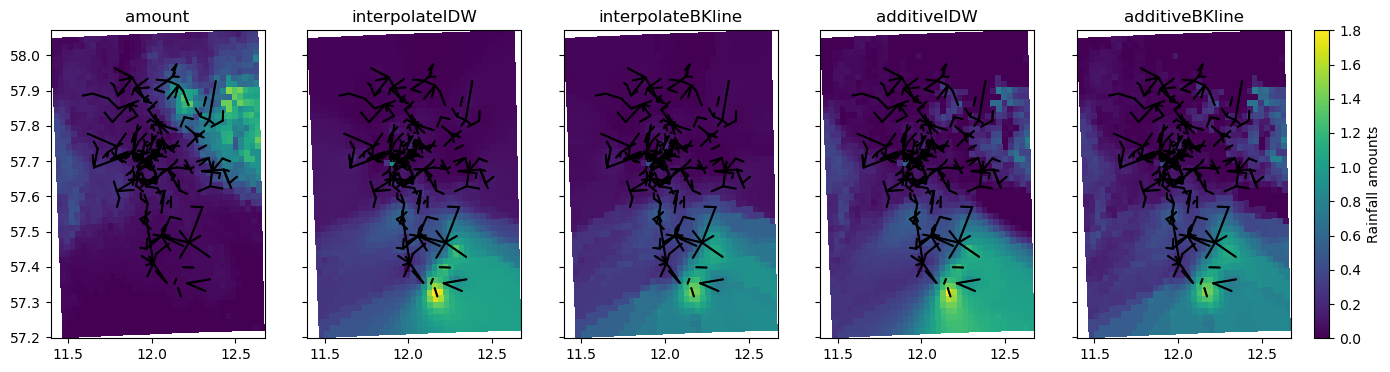

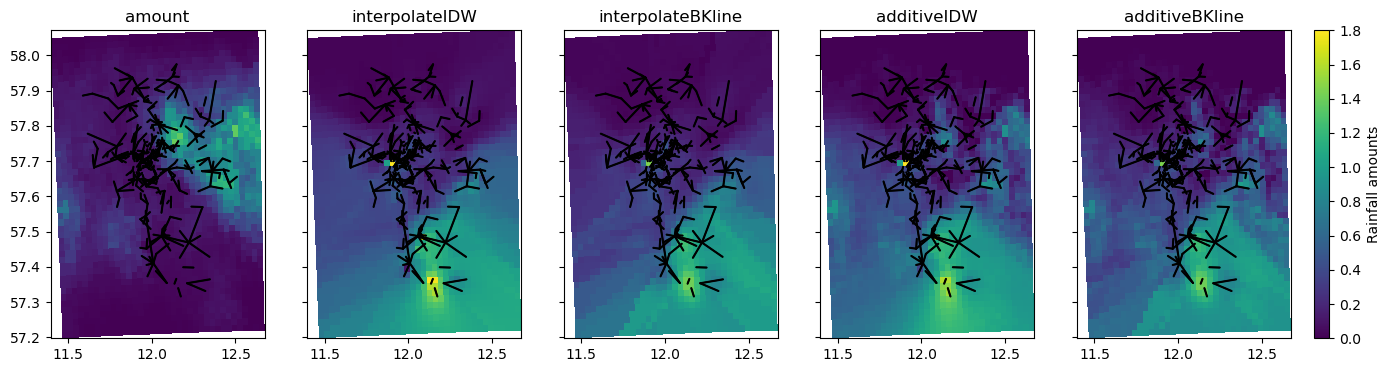

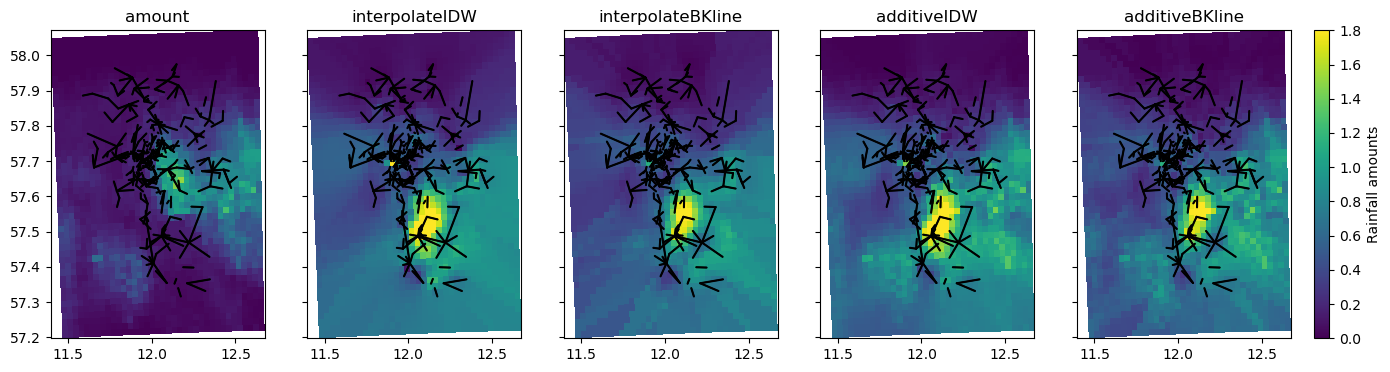

In [18]:
vmax = 1.8  # max color
cmap_rain = "viridis"
# Time interval to plot
time_start = "2015-07-25T12:30"
time_end = "2015-07-25T13:30"

for time in ds_cmls.sel(time=slice(time_start, time_end)).time[:3]:
    fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(20, 4), sharey=True)
    for i, rainfall_field in enumerate(rainfall_fields):
        # Plot rainfall field
        im = ax[i].pcolormesh(
            ds_rad.lon,
            ds_rad.lat,
            ds_rad[rainfall_field].sel(time=time),
            vmin=0,
            vmax=vmax,
            cmap=cmap_rain,
        )

        # Plot postion CMLs
        plg.plot_map.plot_lines(
            ds_cmls,
            use_lon_lat=True,
            ax=ax[i],
            line_color="k",
        )

        ax[i].set_title(rainfall_field.split("_")[1])

    clb = fig.colorbar(im, ax=ax, location="right", anchor=(-0.25, 1.0))
    clb.ax.set_ylabel("Rainfall amounts")
    plt.show()

# Compare to rain gauges

In [19]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad,
    da_point_data=ds_gauges,
    nnear=1,
    stat="best",
)

# Sample rainfall fields
for rainfall_field in rainfall_fields:
    ds_gauges[rainfall_field] = get_grid_at_points(
        da_gridded_data=ds_rad[rainfall_field],
        da_point_data=ds_gauges.R,
    )



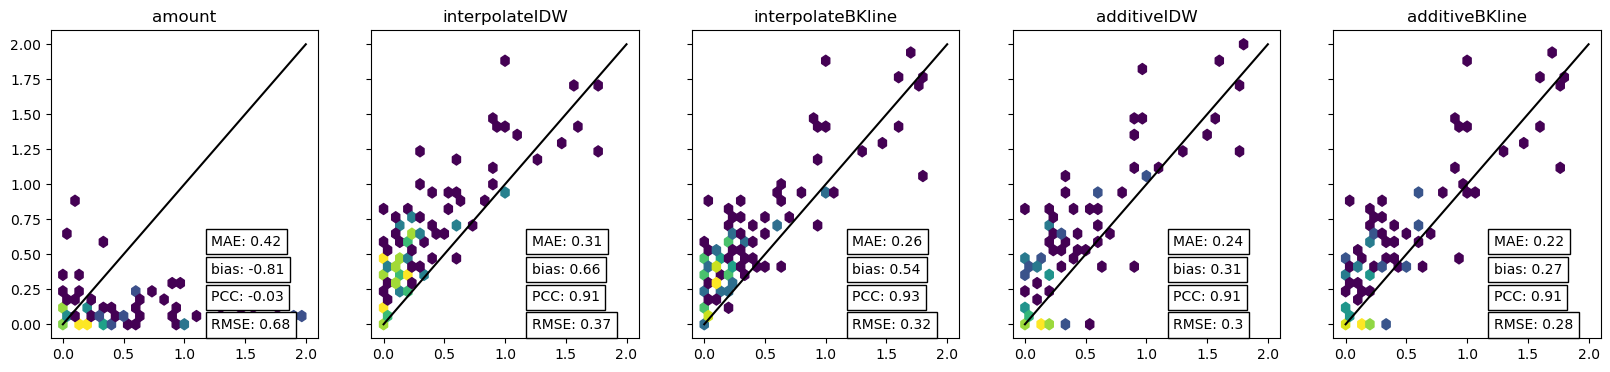

In [20]:
# Plot
vmax = 2
threshold = 0  # Only use above
extent = [0, vmax, 0, vmax]
gridsize = 30

gauge_observed = ds_gauges.R.data.ravel()
fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(20, 4), sharey=True)
for i, rainfall_field in enumerate(rainfall_fields):
    gauge_estimate = ds_gauges[rainfall_field].data.ravel()

    ax[i].hexbin(
        gauge_observed,
        gauge_estimate,
        mincnt=1,
        extent=extent,
        gridsize=gridsize,
        bins="log",
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: "
        + str(round(np.sqrt(np.mean((gauge_observed - gauge_estimate) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(gauge_observed, gauge_estimate)[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(
            round(np.mean(gauge_estimate - gauge_observed) / np.mean(gauge_observed), 2)
        ),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(gauge_estimate - gauge_observed)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")

    ax[i].set_title(rainfall_field.split("_")[1])

